# Minimum Sum of Absolute Errors Regression

In the contemporary context of machine learning, linear regression is a supervised learning technique that produces a linear model to predict values of a dependent variable from known values of one or more independent variables. Linear regression has a long history dating back to at least the 19th century, and is a mainstay of modern data analysis.

This notebook demonstrates linear regression by using to linear programming to minimize a sum of absolute errors between the model prediction and data from a training set. The sum of absolute values of  errors is the $L_1$ norm which is known to have favorable robustness characteristics in practical use. We follow closely this [paper](https://www.jstor.org/stable/1402501).

In [1]:
# Install Pyomo and solvers for Google Colab
import sys
if "google.colab" in sys.modules:
    !wget -N -q https://raw.githubusercontent.com/jckantor/MO-book/main/tools/install_on_colab.py 
    %run install_on_colab.py

## A Wine Quality Dataset


### Downloading the data set

Physical, chemical, and sensory quality properties were collected for a large number of red and white wines produced in the Portugal then donated to the UCI machine learning repository (Cortez, Paulo, Cerdeira, A., Almeida, F., Matos, T. & Reis, J.. (2009). Wine Quality. UCI Machine Learning Repository.) The following cell reads the data for red wines directly from the UCI machine learning repository.

Cortez, P., Cerdeira, A., Almeida, F., Matos, T., & Reis, J. (2009). Modeling wine preferences by data mining from physicochemical properties. Decision support systems, 47(4), 547-553. https://doi.org/10.1016/j.dss.2009.05.016

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

red_wines = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv", sep=";")
red_wines

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


### A preliminary look at the data

The data consists of 1,599 measurements of eleven physical and chemical characteristics plus an integer measure of sensory quality recorded on a scale from 3 to 8. Histograms provides insight into the values and variability of the data set.

NameError: name 'wine_quality' is not defined

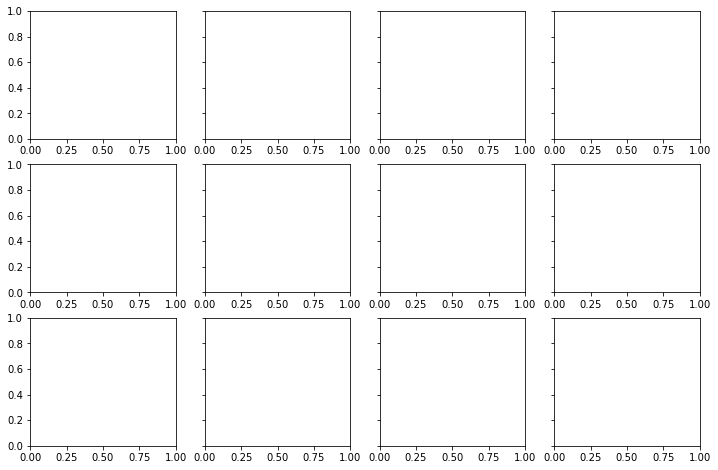

In [3]:
fig, ax = plt.subplots(3, 4, figsize=(12, 8), sharey=True)

for a, column in zip(ax.flatten(), wine_quality.columns):
    red_wines[column].hist(ax=a, bins=30)
    a.axvline(wine_quality[column].mean(), color='r', label="mean")
    a.set_title(column)
    a.legend()
    
plt.tight_layout()

Here the "output" is the reported sensory quality.

In [ ]:
red_wines.corr()["quality"].plot(kind="bar", grid=True)

In [ ]:
ax = wine_quality.boxplot(column="alcohol", by="quality")

## Simple Line Fitting

$$
\begin{align*}
y_i & = a x_i + b + \epsilon_i& \forall i\in I
\end{align*}
$$

$$
\begin{align*}
\min \sum_{i\in I} \left| y_i - a x_i - b \right|
\end{align*}
$$


In [4]:
import pyomo.environ as pyo

def l1_fit_version1(df, y_col, x_col):

    m = pyo.ConcreteModel("L1 Regression Model")

    m.I = pyo.RangeSet(len(red_wines))

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i-1, y_col]

    @m.Param(m.I)
    def X(m, i):
        return df.loc[i-1, x_col]

    # regression
    m.a = pyo.Var()
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)
                            
    @m.Expression(m.I)
    def prediction(m, i):
        return m.a * m.X[i] + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m .y[i]

    @m.Objective(sense=pyo.minimize)
    def sum_of_absolute_values(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I)

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = l1_fit_version1(red_wines, "quality", "alcohol")
print(m.sum_of_absolute_values())

865.3253941370053


In [5]:
vars = {i: l1_fit_version1(red_wines, "quality", i).sum_of_absolute_values() for i in red_wines.columns}

<AxesSubplot:>

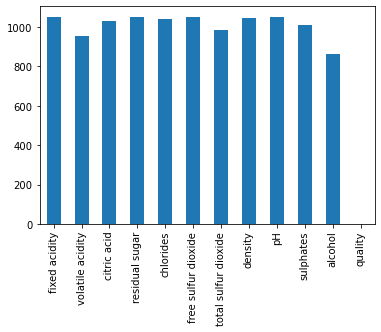

In [6]:
pd.Series(vars).plot(kind="bar")

<AxesSubplot:xlabel='quality', ylabel='prediction'>

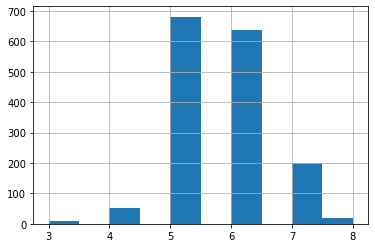

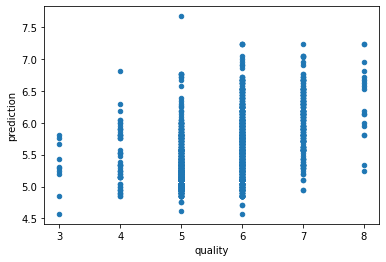

In [7]:
red_wines["prediction"] = [m.prediction[i]() for i in m.I]
red_wines["quality"].hist(label="data")

red_wines.plot(x="quality", y="prediction", kind="scatter")

## Multivariable Regression

799.1757322626268
alcohol  0.34242497
volatile acidity  -0.98061746
citric acid  -0.28927641
sulphates  0.90609119
total sulfur dioxide  -0.0021873578
density  -18.500829
fixed acidity  0.063818378


<AxesSubplot:xlabel='quality', ylabel='prediction'>

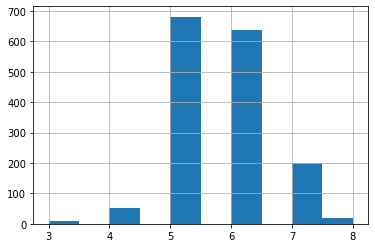

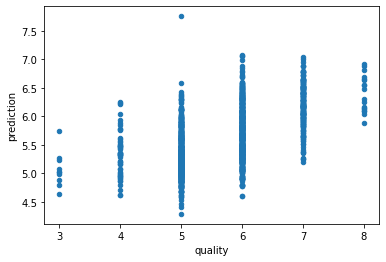

In [212]:
import pyomo.environ as pyo

def l1_fit_version2(df, y_col, x_cols):

    m = pyo.ConcreteModel("L1 Regression Model")

    m.I = pyo.RangeSet(len(red_wines))
    m.J = pyo.Set(initialize=x_cols)

    @m.Param(m.I)
    def y(m, i):
        return df.loc[i-1, y_col]

    @m.Param(m.I, m.J)
    def X(m, i, j):
        return df.loc[i-1, j]

    # regression
    m.a = pyo.Var(m.J)
    m.b = pyo.Var(domain=pyo.Reals)

    m.e_pos = pyo.Var(m.I, domain=pyo.NonNegativeReals)
    m.e_neg = pyo.Var(m.I, domain=pyo.NonNegativeReals)
                            
    @m.Expression(m.I)
    def prediction(m, i):
        return sum(m.a[j] * m.X[i, j] for j in m.J) + m.b

    @m.Constraint(m.I)
    def prediction_error(m, i):
        return m.e_pos[i] - m.e_neg[i] == m.prediction[i] - m.y[i]

    @m.Objective(sense=pyo.minimize)
    def sum_of_absolute_values(m):
        return sum(m.e_pos[i] + m.e_neg[i] for i in m.I)

    pyo.SolverFactory('cbc').solve(m)
    
    return m

m = l1_fit_version2(red_wines, "quality", 
                    ["alcohol", "volatile acidity", "citric acid", "sulphates", \
                     "total sulfur dioxide", "density", "fixed acidity"])
print(m.sum_of_absolute_values())

for j in m.J:
    print(f"{j}  {m.a[j]()}")

red_wines["prediction"] = [m.prediction[i]() for i in m.I]
red_wines["quality"].hist(label="data")

red_wines.plot(x="quality", y="prediction", kind="scatter")


In [67]:
import pyomo.environ as pyo

l1 = pyo.ConcreteModel("L1 Regression Model")

l1.I = pyo.RangeSet(len(wine_quality))
l1.J = pyo.Set(initialize=["alcohol"])

@l1.Param(l1.I)
def y(l1, i):
    return wine_quality.loc[i-1, "quality"]

@l1.Param(l1.I, l1.J)
def X(l1, i, j):
    return wine_quality.loc[i-1, j]

l1.m = pyo.Var()
l1.b = pyo.Var()

l1.e_pos = pyo.Var(l1.I, domain=pyo.NonNegativeReals)
l1.e_neg = pyo.Var(l1.I, domain=pyo.NonNegativeReals)

@l1.Constraint(l1.I)
def regression(l1, i):
    return l1.e_pos[i] - l1.e_neg[i] == l1.y[i] - l1.X[i]*l1.m - l1.b

@l1.Objective()
def sum_of_absolute_values(l1):
    return sum(l1.e_pos[i] + l1.e_neg[i] for i in l1.I)

pyo.SolverFactory('cbc').solve(l1)

print(l1.m(), l1.b())
wine_quality["prediction"] = l1.m()*wine_quality["alcohol"] + l1.b()
wine_quality["prediction error"] = wine_quality["prediction"] - wine_quality["quality"]

#ax = wine_quality.plot(x="alcohol", y=["quality"], kind="scatter")
#wine_quality.plot(x="alcohol", y=["prediction"], ax=ax)

ax = wine_quality["quality"].hist()
wine_quality["prediction"].hist(ax=ax)

ERROR: Rule failed when generating expression for Constraint regression with
    index 1: KeyError: "Index '1' is not valid for indexed component 'X'"
ERROR: Constructing component 'regression' from data=None failed: KeyError:
    "Index '1' is not valid for indexed component 'X'"


KeyError: "Index '1' is not valid for indexed component 'X'"

# Generate data

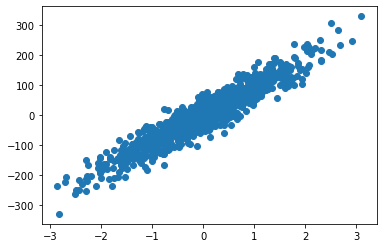

In [34]:
from sklearn.datasets import make_regression
import matplotlib.pyplot as plt
import numpy as np

n_features = 1
n_samples = 1000
noise = 30

# generate regression dataset
np.random.seed(2020)
X, y = make_regression(n_samples=n_samples, n_features=n_features, noise=noise)

if n_features == 1:
    plt.scatter(X, y)
    plt.show()

# Model



In [35]:
import pyomo.environ as pyo

In [36]:
m = pyo.ConcreteModel('min abs')

In [37]:
n, k = X.shape

In [38]:
m.I = pyo.RangeSet(0, n-1)
m.J = pyo.RangeSet(0, k-1)

In [39]:
m.ep = pyo.Var(m.I, domain=pyo.NonNegativeReals)
m.em = pyo.Var(m.I, domain=pyo.NonNegativeReals)
m.m = pyo.Var(m.J)
m.b = pyo.Var()

In [40]:
@m.Constraint(m.I)
def fit(m, i):
    return y[i] == m.b + m.ep[i] - m.em[i] + sum(X[i][j]*m.m[j] for j in m.J)

In [41]:
@m.Objective(sense=pyo.minimize)
def obj(m):
    return sum(m.ep[i] + m.em[i] for i in m.I)

In [42]:
%time pyo.SolverFactory('glpk').solve(m)

CPU times: user 79.6 ms, sys: 14 ms, total: 93.6 ms
Wall time: 199 ms


{'Problem': [{'Name': 'unknown', 'Lower bound': 23438.9432109967, 'Upper bound': 23438.9432109967, 'Number of objectives': 1, 'Number of constraints': 1001, 'Number of variables': 2003, 'Number of nonzeros': 4001, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.11536598205566406}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

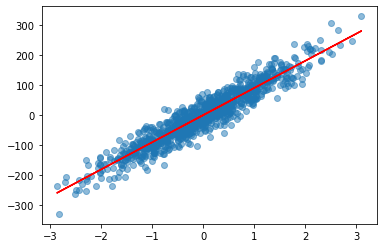

In [43]:
if n_features ==  1:
    plt.scatter(X, y, alpha=0.5)
    plt.plot([x[0] for x in X], [pyo.value(m.b) + pyo.value(m.m[0])*x[0] for x in X ], 'r')
    plt.show()
else:
    print( pyo.value(m.b),[pyo.value(m) for m in m.m.values() ] )